

<h1 align=center><font size = 5>LONDON VS PARIS</font></h1>

## Introduction

Among the best cities to visit in Europe, Paris and London are two historical cities that are well rated. It is sure that, we don't have the same criteria to state how much we like a city over an other. The reasons can be very diverse from one person to another. Something is certain, if not ,let's make it an assumption, What   people may like in a city is about how they can enjoy themselves there : food, drink, art, culture, park, nightlife and so on... To put in a nutshell, people may be interested in the type of activities they can have. One can relevantly wonders if London and Paris meet this expectation. We will not discuss demography data in this project.
Furthermore,as far as tourism is concerned, weather is also an important subject. The impact of weather on tourism may depends on various parameters such as precipitation, sun, temperature, most common day condition. We must also take into account that, the weather preference can differ with the kinds of activities that a tourist may pursue. You know what? Nevermind! To make it simple and less theoretical, Let's just assume that a blue sky is most appreciated than a grey one.
A most spread idea is that London has a very bad weather and it rains pretty much there. Is it only a 'cliché'?
Anyway, for people who want to enjoy outdoors under the sun, this might not be a positive intel.

## Problem

The main problem we will discuss is whether Paris is so different of London. 
We are going to argue how similar and dissimilar London and Paris are.

## Target audience of the project

The topic may interest anyone particularly prospective tourists who want to know the two cities and decide where to go for holidays.

## How we are going to work

To achieve our goal, our work will consist in two big parts. Firstly, we are going to explore both cities in order to discover the kind of attractions/stuffs one can enjoy in London and Paris. Then we are going to analyze and compare the weather is both cities.

## Data

The data we will need for this project are:
  * list of stuffs/places/attraction of interest in both cities: We are going to leverage on the Foursquare API to get the information we need. It is very important that for each place we get the category that we can aggregate on.
  * Historical weather data for last year: We will need for each day in 2018, the temperature,precipitation amount, presence of sun and the global day condition. We will use the worldweatheronline API to get our data.

## METHODOLODY

We will use the foursquare API to get the venues within 2000 meters for each town. We will set the limit of venues to 1000 just to make sure that we get all the venues available in the area. The result will be a JSON that from which we are going to extract the categories. We will need to redefine the categories so that we don't end up with 30 categories. We will discuss whether the repartition of venues is quite the same in both cities or not.
Then, we are going to use the worldweatheronline API to get historical weather data for both towns. The result is a JSON from which we can extract for each day: average temperature, maximum temperature, minimum temperature, precipitation, day condition, total sun hour... Using these data, we are going to analyze and compare the weather of the two cities.




# HERE WE GO


Lets import the modules we need

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
#import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    nu

<a id='item1'></a>

## 1. Exploring both cities

In [3]:
#here is the function to get the coordinates of a city
def get_geo_coor(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))
    return latitude,longitude

In [4]:
london_latitude , london_longitude = get_geo_coor('London, UK')
paris_latitude , paris_longitude = get_geo_coor('Paris, FRANCE')

The geograpical coordinate of London, UK are 51.5073219, -0.1276474.
The geograpical coordinate of Paris, FRANCE are 48.8566101, 2.3514992.


#### Foursquare Credentials and Version

In [1]:

CLIENT_ID = '-' #HIDDEN
CLIENT_SECRET = '-' # your Foursquare Secret
VERSION = '20201110'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: -
CLIENT_SECRET:-


#### Now, let's get the top 1000 venues  within a radius of 1000 meters.

Defining  the function to get venues and their category. 

In [7]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def get_category_group(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        text= categories_list[0]['icon']['prefix']
        text =text[text.index('categories_v2/')+14:]
        text[:text.index('/')]
        return text[:text.index('/')]
    
def get_venues(search_query,latitude,longitude,radius,LIMIT):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        latitude, 
        longitude, 
        VERSION, 
        search_query, 
        radius, LIMIT)

   

    
    results = requests.get(url).json()
    venues = results['response']['venues']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    #filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    #nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['categories_group'] = nearby_venues.apply(get_category_group, axis=1)
    nearby_venues['categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    nearby_venues = nearby_venues[['name','categories','categories_group','lat','lng']]

    #print(nearby_venues.head())
    return nearby_venues


Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [8]:
london_venues = get_venues('',london_latitude,london_longitude,2000,1000)
paris_venues = get_venues('',paris_latitude,paris_longitude,2000,1000)

## Let see  'categories_group'

In [10]:
london_venues.categories_group.drop_duplicates()

0          parks_outdoors
1                building
2      arts_entertainment
4                   shops
8                    food
10                 travel
15              nightlife
94              education
107                  None
120                 event
Name: categories_group, dtype: object

<a id='item2'></a>

In [11]:
paris_venues.categories_group.drop_duplicates()

0         parks_outdoors
2               building
4     arts_entertainment
5                  shops
6                   food
16                travel
17                  None
37             nightlife
Name: categories_group, dtype: object

## Number of each category in each town

In [27]:
london_group = london_venues.groupby('categories_group').count().sort_values(by='name',ascending=False)
#london_group['london']=london_group['name'].apply(lambda x: round(x/london_venues.shape[0]*100,2))
london_group['london']=london_group['name'].apply(lambda x: int(x))
london_group

,name,categories,lat,lng,london
categories_group,,,,,
building,44,44,44,44,44
shops,30,30,30,30,30
food,22,22,22,22,22
parks_outdoors,15,15,15,15,15
travel,13,13,13,13,13
nightlife,11,11,11,11,11
arts_entertainment,8,8,8,8,8
education,1,1,1,1,1
event,1,1,1,1,1


In [26]:
paris_group = paris_venues.groupby('categories_group').count().sort_values(by='name',ascending=False)
#paris_group['paris']=paris_group['name'].apply(lambda x: round(x/paris_venues.shape[0]*100,2))
paris_group['paris']=paris_group['name'].apply(lambda x: int(x))
paris_group

,name,categories,lat,lng,paris
categories_group,,,,,
shops,13,13,13,13,13
building,9,9,9,9,9
food,9,9,9,9,9
parks_outdoors,5,5,5,5,5
travel,5,5,5,5,5
arts_entertainment,1,1,1,1,1
nightlife,1,1,1,1,1


In [28]:
town_activities = pd.merge(paris_group, london_group, left_on='categories_group',right_on='categories_group')[['paris','london']]

Text(0, 0.5, 'Number')

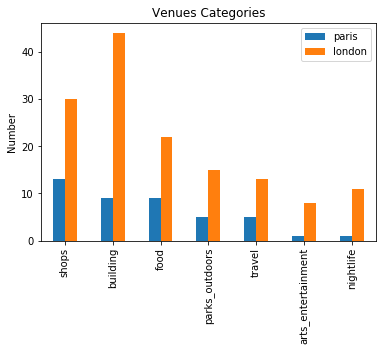

In [30]:
ax = town_activities.plot.bar(title='Venues Categories')
ax.set_xlabel("")
ax.set_ylabel("Number")

## Comment

We obviously see that there are more places of interest in London than in Paris. It is important to know that London is ten time bigger than Paris. We are just comparing the area between 2km from the center of both cities.

Lets see instead the percentage of each category in each cities.



Text(0, 0.5, 'PCt %')

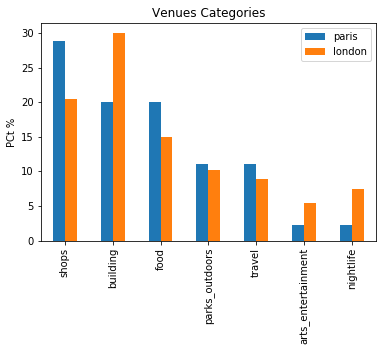

In [31]:
paris_group['paris']=paris_group['name'].apply(lambda x: round(x/paris_venues.shape[0]*100,2))
london_group['london']=london_group['name'].apply(lambda x: round(x/london_venues.shape[0]*100,2))
town_activities = pd.merge(paris_group, london_group, left_on='categories_group',right_on='categories_group')[['paris','london']]
ax = town_activities.plot.bar(title='Venues Categories')
ax.set_xlabel("")
ax.set_ylabel("PCt %")

In term of frequence.It seem In Paris, we have more shops and everything else whereas in London, the most common category is building.
Food area seems to be more frequent in Paris than in London.

In [32]:
london_venues[london_venues['categories_group']=='building'].categories.drop_duplicates()

1                                        Office
3                           Monument / Landmark
34                               Police Station
38                           Advertising Agency
46                             Business Service
53                              Coworking Space
55                          Government Building
76                                  Event Space
81                                     Building
100                 Professional & Other Places
114                                  Non-Profit
117                             Conference Room
127    Residential Building (Apartment / Condo)
128                                         Gym
132                             Campaign Office
133                                Meeting Room
136                                  Club House
138                                     Parking
146                             Business Center
Name: categories, dtype: object

In [33]:
paris_venues[paris_venues['categories_group']=='building'].categories.drop_duplicates()

2           City Hall
7              Church
8              Office
9         Post Office
10     Police Station
38     Medical Center
39    Doctor's Office
41    Campaign Office
Name: categories, dtype: object

In [34]:
paris_venues[paris_venues['categories_group']=='parks_outdoors'].categories.drop_duplicates()

0      Plaza
1     Bridge
3      River
28    Garden
42      Park
Name: categories, dtype: object

In [35]:
london_venues[london_venues['categories_group']=='parks_outdoors'].categories.drop_duplicates()

0                 Plaza
7     Outdoor Sculpture
9              Fountain
19           Campground
21     Botanical Garden
56       Scenic Lookout
Name: categories, dtype: object

### Let examine the type of shops for each town

<a id='item5'></a>

In [37]:
london_venues[london_venues['categories_group']=='shops'].categories.drop_duplicates()

4                   Grocery Store
5                       Gift Shop
6                            Bank
12                      Bookstore
20                    Supermarket
26       Bike Rental / Bike Share
29             Salon / Barbershop
31     Financial or Legal Service
32             Miscellaneous Shop
36                       Car Wash
41                   Tech Startup
48        Health & Beauty Service
75                  Jewelry Store
77                 Massage Studio
91                  Women's Store
99                 Cosmetics Shop
103             Electronics Store
118                Shopping Plaza
124                Clothing Store
140               Automotive Shop
142                   Gaming Cafe
Name: categories, dtype: object

In [36]:
paris_venues[paris_venues['categories_group']=='shops'].categories.drop_duplicates()

5               Cosmetics Shop
11                   Gift Shop
12                Perfume Shop
14    Bike Rental / Bike Share
15               Souvenir Shop
20                 Supermarket
26                  Shoe Store
27               Jewelry Store
29      Furniture / Home Store
32               Women's Store
Name: categories, dtype: object

# Th weather

In [50]:
#credentials for https://www.worldweatheronline.com/
    
apiKey ="-"#hidden
freeHttpsUrl = 'https://api.worldweatheronline.com/free/v2/weather.ashx'
premiumHttpsUrl = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx'

In [43]:
url = premiumHttpsUrl+'?q={}&date={}&enddate={}&key={}&tp=24&format=json'.format('London','2018-01-01','2018-12-31',apiKey)

In [40]:
ret =requests.get(url).json()

In [48]:
raw_data={'London':[],'Paris':[]}
#for some reasons i cant directly get data from january to december. So im going to get it by month
for dates in [('2018-01-01','2018-01-31'),('2018-02-01','2018-02-28'),
             ('2018-03-01','2018-03-31'),('2018-04-01','2018-04-30'),
              ('2018-05-01','2018-05-31'),('2018-06-01','2018-06-30'),
             ('2018-07-01','2018-07-31'),('2018-08-01','2018-08-31'),
             ('2018-09-01','2018-09-30'),('2018-10-01','2018-10-31'),
             ('2018-11-01','2018-11-30'),('2018-12-01','2018-12-31')]:
    for key in raw_data:
        url = premiumHttpsUrl+'?q={}&date={}&enddate={}&key={}&tp=24&format=json'.format(key,dates[0],dates[1],apiKey)
        ret =requests.get(url).json()
        raw_data[key].extend(ret['data']['weather'])
    

Let's make sure we have 365 days data

In [51]:
len([x['date'] for x in raw_data['London']])

365

In [52]:
len([x['date'] for x in raw_data['Paris']])

365

Let's get a sample data for a day 

In [53]:
raw_data['London'][0]

{'date': '2018-01-01',
 'astronomy': [{'sunrise': '08:06 AM',
   'sunset': '04:02 PM',
   'moonrise': '03:48 PM',
   'moonset': '07:00 AM',
   'moon_phase': 'Waxing Gibbous',
   'moon_illumination': '97'}],
 'maxtempC': '8',
 'maxtempF': '46',
 'mintempC': '6',
 'mintempF': '43',
 'avgtempC': '7',
 'avgtempF': '44',
 'totalSnow_cm': '0.0',
 'sunHour': '6.8',
 'uvIndex': '3',
 'hourly': [{'time': '24',
   'tempC': '8',
   'tempF': '46',
   'windspeedMiles': '12',
   'windspeedKmph': '19',
   'winddirDegree': '250',
   'winddir16Point': 'WSW',
   'weatherCode': '113',
   'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.net/images/wsymbols01_png_64/wsymbol_0001_sunny.png'}],
   'weatherDesc': [{'value': 'Sunny'}],
   'precipMM': '0.4',
   'precipInches': '0.0',
   'humidity': '71',
   'visibility': '10',
   'visibilityMiles': '6',
   'pressure': '998',
   'pressureInches': '30',
   'cloudcover': '32',
   'HeatIndexC': '7',
   'HeatIndexF': '45',
   'DewPointC': '2',
   'DewPoin

In [54]:
data_required = [{'town':'Paris','date':x['date'],'avgtempC':x['avgtempC'],'mintempC':x['mintempC'],'maxtempC':x['maxtempC'],
                  'precipMM':x['hourly'][0]['precipMM'],'weatherCode':x['hourly'][0]['weatherCode'],'cloudcover':x['hourly'][0]['cloudcover'],
                  'sunHour':x['sunHour']} for x in raw_data['Paris']]
data_required.extend( [{'town':'London','date':x['date'],'avgtempC':x['avgtempC'],'mintempC':x['mintempC'],'maxtempC':x['maxtempC'],
                  'precipMM':x['hourly'][0]['precipMM'],'weatherCode':x['hourly'][0]['weatherCode'],'cloudcover':x['hourly'][0]['cloudcover'],'sunHour':x['sunHour']} for x in raw_data['London']])

In [55]:
weather_data = pd.DataFrame(data_required)
weather_data.head()


,town,date,avgtempC,mintempC,maxtempC,precipMM,weatherCode,cloudcover,sunHour
0,Paris,2018-01-01,8,7,9,0.1,116,56,3.2
1,Paris,2018-01-02,7,5,11,1.0,122,71,3.2
2,Paris,2018-01-03,11,9,15,1.6,122,89,5.1
3,Paris,2018-01-04,11,9,14,9.2,143,78,3.2
4,Paris,2018-01-05,9,7,11,0.6,122,67,5.1


In [91]:
weather_data.tail()

,town,date,avgtempC,mintempC,maxtempC,precipMM,weatherCode,cloudcover,sunHour
725,London,2018-12-27,6,5,7,0.0,116,68,6.7
726,London,2018-12-28,6,5,8,0.0,122,65,4.8
727,London,2018-12-29,8,6,11,0.0,116,68,4.8
728,London,2018-12-30,8,7,10,0.0,116,84,6.8
729,London,2018-12-31,8,6,9,0.0,116,62,4.9


In [56]:
#saving the data just in case

weather_data.to_csv("weather_data.csv")

Defining date_index in date type

In [58]:
dates = pd.date_range("1 1 2018", periods=365, freq="D")
weather_data['date_index'] = dates.append(dates)

converting the colums to float

In [59]:
for column in ['avgtempC','mintempC','maxtempC','precipMM','weatherCode','cloudcover','sunHour',]:
    weather_data[column] = pd.to_numeric(weather_data[column], downcast='float')

In [60]:
weather_data['month'] = weather_data['date'].apply(lambda x: x.split('-')[1])

In [61]:
weather_data.loc[weather_data['town']=='London'].dtypes

town                   object
date                   object
avgtempC              float32
mintempC              float32
maxtempC              float32
precipMM              float32
weatherCode           float32
cloudcover            float32
sunHour               float32
date_index     datetime64[ns]
month                  object
dtype: object

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import calendar



# temperature

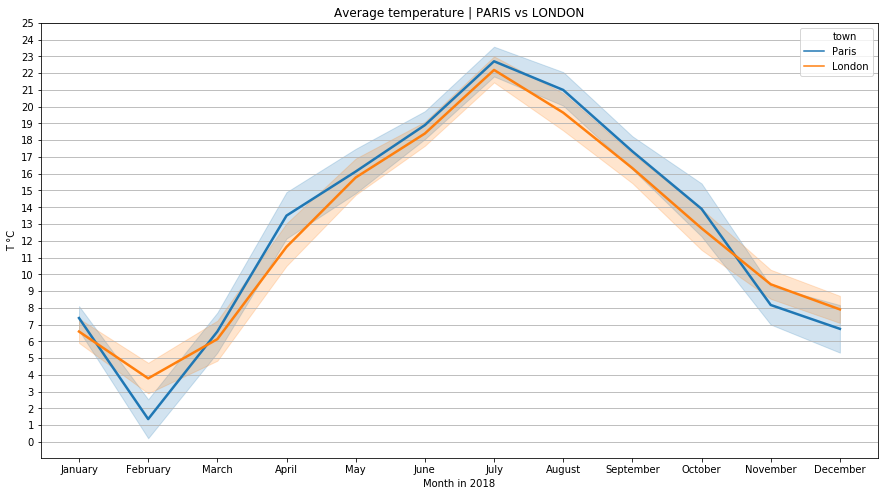

In [155]:
fig = plt.figure(figsize=(15,8))
ax = sns.lineplot(x="month", y="avgtempC", data=weather_data, hue='town',linewidth=2.5,palette=["C0", "C1"])
ax.set_xticks(np.arange(12))
ax.set_xticklabels(calendar.month_name[1:13])
ax.set_yticks(np.linspace(0, 25, num=26))
ax.set_xlabel("Month in 2018")
ax.set_ylabel("T °C")
ax.set_title("Average temperature | PARIS vs LONDON")
ax.grid(b=True,axis ='y')
fig.savefig('avgtempC.png', dpi = 300)

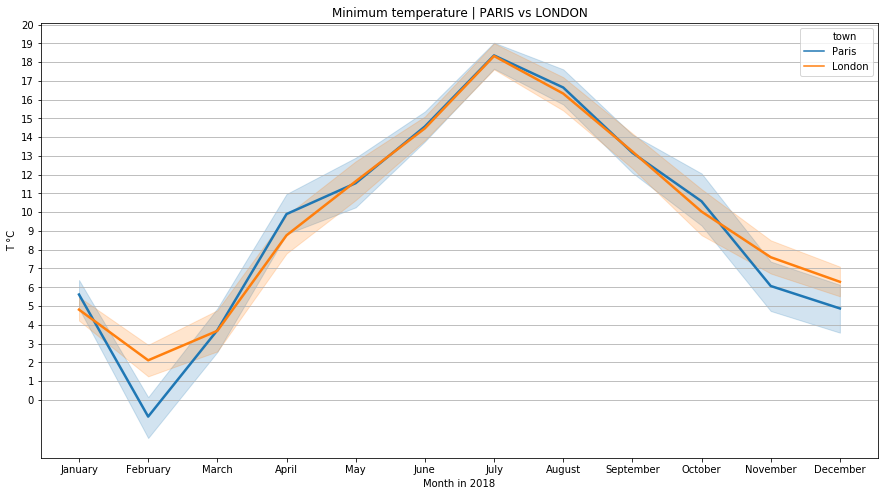

In [152]:

fig = plt.figure(figsize=(15,8))
ax = sns.lineplot(x="month", y="mintempC", data=weather_data, hue='town',linewidth=2.5)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(calendar.month_name[1:13])
ax.set_yticks(np.linspace(0, 20, num=21))

ax.set_xlabel("Month in 2018")
ax.set_ylabel("T °C")
ax.grid(b=True,axis ='y')
ax.set_title("Minimum temperature | PARIS vs LONDON")
fig.savefig('mintempC.png', dpi = 300)

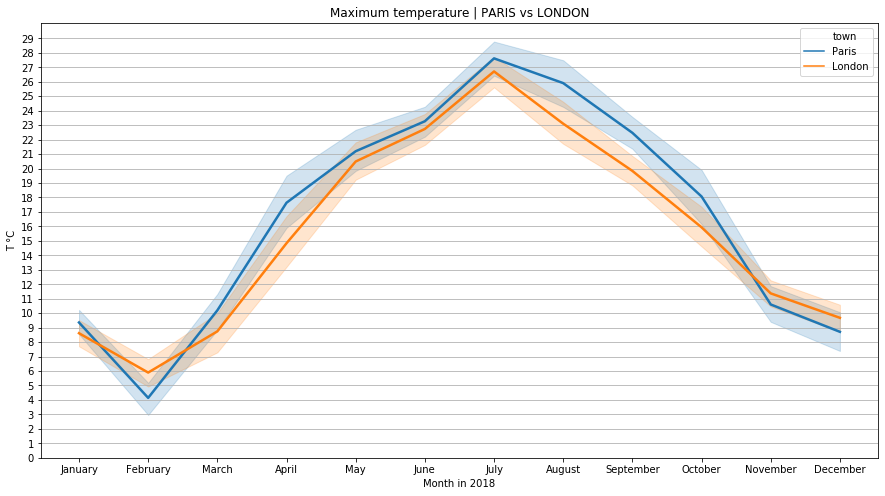

In [147]:
fig = plt.figure(figsize=(15,8))
ax = sns.lineplot(x="month", y="maxtempC", data=weather_data, hue='town',linewidth=2.5)
ax.set_xticks(np.arange(12))
ax.set_yticks(np.linspace(0, 29, num=30))
#ax.set_yticks([int(x) for x in np.linspace(0, 30, num=30)])
ax.set_xticklabels(calendar.month_name[1:13])
ax.set_xlabel("Month in 2018")
ax.set_ylabel("T °C")
ax.grid(b=True,axis ='y')

ax.set_title("Maximum temperature | PARIS vs LONDON")
fig.savefig('maxtempC.png', dpi = 300)

# RAIN FALL

### average by day

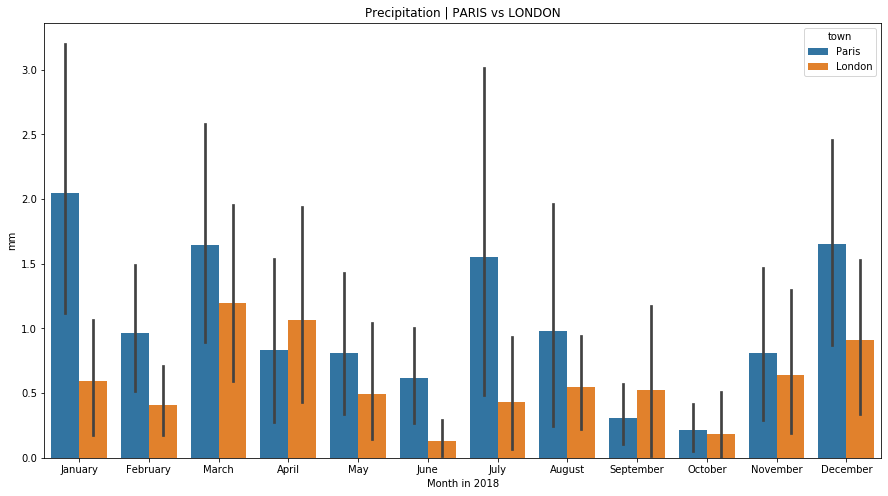

In [88]:
fig = plt.figure(figsize=(15,8))
ax = sns.barplot(x="month", y="precipMM", data=weather_data, hue='town',linewidth=2.5)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(calendar.month_name[1:13])
ax.set_xlabel("Month in 2018")
ax.set_ylabel("mm")
ax.set_title("Precipitation | PARIS vs LONDON")
fig.savefig('precipMM.png', dpi = 300)

### sum of precipitation in the month

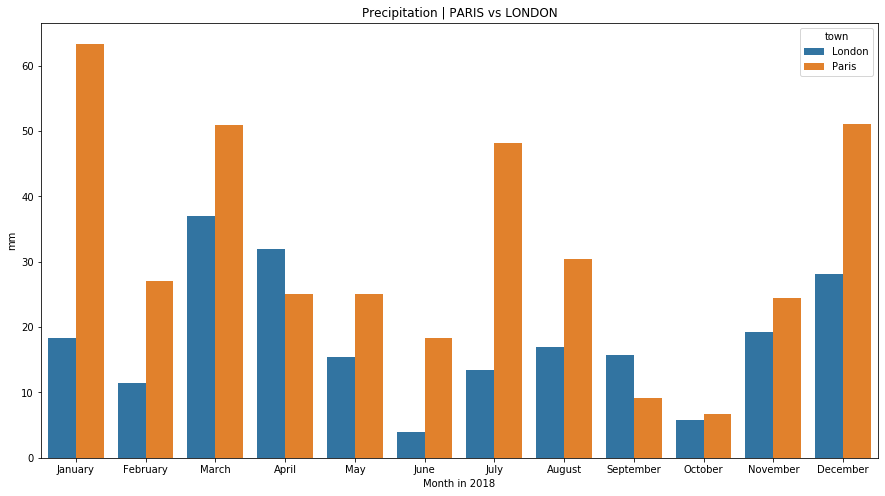

In [140]:
fig = plt.figure(figsize=(15,8))
ax = sns.barplot(x="month", y="precipMM", data=weather_data.groupby(['month','town']).sum().reset_index(), hue='town',linewidth=2.5)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(calendar.month_name[1:13])
ax.set_xlabel("Month in 2018")
ax.set_ylabel("mm")
ax.set_title("Precipitation | PARIS vs LONDON")
fig.savefig('precipMM_sum.png', dpi = 300)

In [91]:
weather_data.groupby('month').sum().reset_index()

,month,avgtempC,mintempC,maxtempC,precipMM,weatherCode,cloudcover,sunHour
0,01,433.0,323.0,557.0,81.800003,7411.0,4163.0,325.299988
1,02,144.0,34.0,281.0,38.500000,6721.0,2817.0,389.100006
2,03,394.0,229.0,587.0,88.000000,7804.0,4329.0,491.399994
3,04,754.0,560.0,974.0,57.000000,7041.0,3190.0,666.200012
4,05,989.0,719.0,1292.0,40.400002,7126.0,2030.0,834.400024
5,06,1119.0,871.0,1380.0,22.299999,6999.0,2176.0,793.599976
6,07,1392.0,1137.0,1684.0,61.599998,7237.0,2121.0,833.900024
7,08,1260.0,1022.0,1519.0,47.299999,7153.0,2224.0,777.900024
8,09,1010.0,792.0,1269.0,25.000000,6888.0,1904.0,661.000000
9,10,826.0,639.0,1054.0,12.500000,7153.0,2219.0,487.299988


Surprisingly more rain falls in Paris than London. April is the only month when more rain falls on London than Paris.

# sun

In [92]:
weather_data['total_hour_in_a_day']=weather_data['date'].apply(lambda x: 24)

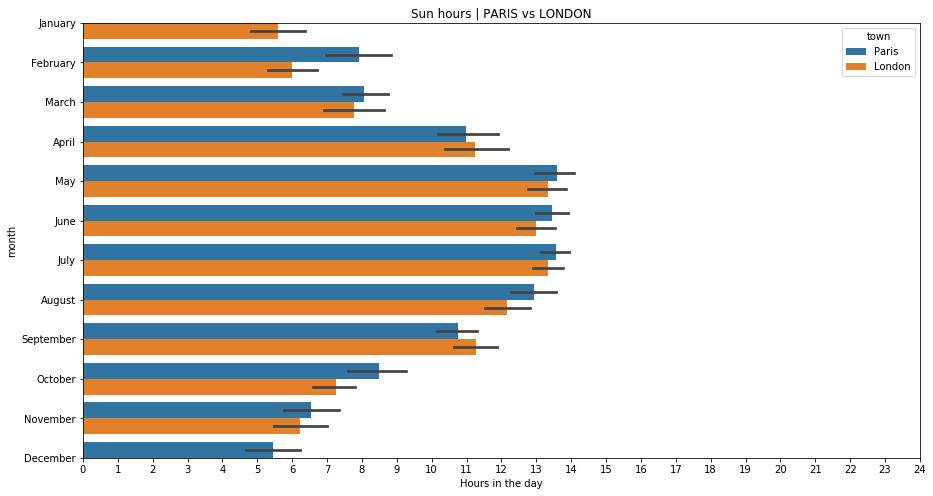

In [110]:


fig = plt.figure(figsize=(15,8))
#ax2=sns.barplot(y="month", x="total_hour_in_a_day", data=weather_data, hue='town',linewidth=2.5,orient='h',color='grey')
ax1=sns.barplot(y="month", x="sunHour", data=weather_data, hue='town',linewidth=2.5,orient='h')
ax1.set_xticks(np.arange(25))
ax1.set_xticklabels(np.arange(25))
ax1.set_xlabel("Hours in the day")
ax1.set_ylabel("month")
ax1.set_yticks(np.arange(13))
ax1.set_yticklabels(calendar.month_name[1:14])
ax1.set_title("Sun hours | PARIS vs LONDON")
fig.savefig('sunhour.png', dpi = 300)

# day condition

In [111]:
weather_code = pd.read_csv('http://www.worldweatheronline.com/feed/Multilingual_Weather_Conditions.csv',usecols=[0,1])

In [112]:
weather_code.drop_duplicates('overhead_code',inplace= True)
weather_code


,overhead_code,daycondition
0,113,Sunny
40,116,Partly cloudy
80,119,Cloudy
120,122,Overcast
160,143,Mist
200,176,Patchy rain possible
240,179,Patchy snow possible
280,182,Patchy sleet possible
320,185,Patchy freezing drizzle possible
360,200,Thundery outbreaks possible


In [113]:
weather_data_merged =pd.merge(weather_data,weather_code,left_on='weatherCode', right_on='overhead_code')
weather_data_merged.head()

,town,date,avgtempC,mintempC,maxtempC,precipMM,weatherCode,cloudcover,sunHour,date_index,month,total_hour_in_a_day,overhead_code,daycondition
0,Paris,2018-01-01,8.0,7.0,9.0,0.1,116.0,56.0,3.2,2018-01-01,01,24,116,Partly cloudy
1,Paris,2018-01-08,5.0,4.0,8.0,0.0,116.0,65.0,8.7,2018-01-08,01,24,116,Partly cloudy
2,Paris,2018-01-13,4.0,2.0,6.0,0.0,116.0,47.0,8.7,2018-01-13,01,24,116,Partly cloudy
3,Paris,2018-01-16,8.0,7.0,10.0,3.1,116.0,71.0,3.3,2018-01-16,01,24,116,Partly cloudy
4,Paris,2018-01-17,6.0,4.0,7.0,0.7,116.0,61.0,8.7,2018-01-17,01,24,116,Partly cloudy


In [114]:
#There are too many daycondition. We are going to aggregate them in 6 categories
def get_simple_day_condition(code):
    if int(code) == 113:
        return 'Sunny'
    elif int(code) <176 :
        return 'Cloudy'
    elif int(code) ==176 :
        return 'Rainy'
    elif int(code) <231 :
        return 'Snowy'
    elif int(code) <293 :
        return 'Foggy'
    else :
        return 'Rainy'

In [115]:
weather_data_merged['day_condition_simple']=weather_data_merged['weatherCode'].apply(get_simple_day_condition)
weather_data_merged['day_condition_simple'].unique()

array(['Cloudy', 'Sunny', 'Rainy', 'Snowy'], dtype=object)

In [116]:
weather_data_merged.groupby(['day_condition_simple','town']).count().reset_index()

,day_condition_simple,town,date,avgtempC,mintempC,maxtempC,precipMM,weatherCode,cloudcover,sunHour,date_index,month,total_hour_in_a_day,overhead_code,daycondition
0,Cloudy,London,214,214,214,214,214,214,214,214,214,214,214,214,214
1,Cloudy,Paris,196,196,196,196,196,196,196,196,196,196,196,196,196
2,Rainy,London,1,1,1,1,1,1,1,1,1,1,1,1,1
3,Rainy,Paris,4,4,4,4,4,4,4,4,4,4,4,4,4
4,Snowy,Paris,2,2,2,2,2,2,2,2,2,2,2,2,2
5,Sunny,London,150,150,150,150,150,150,150,150,150,150,150,150,150
6,Sunny,Paris,163,163,163,163,163,163,163,163,163,163,163,163,163


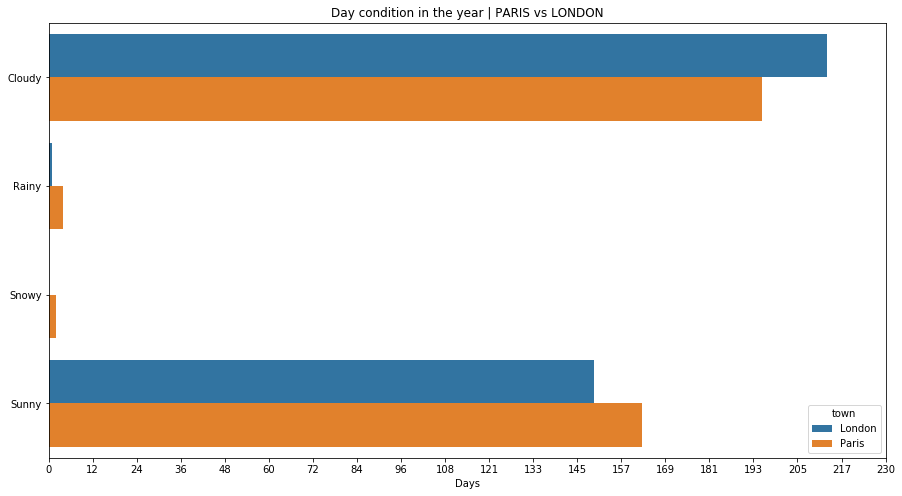

In [131]:


fig = plt.figure(figsize=(15,8))
#ax2=sns.barplot(y="month", x="total_hour_in_a_day", data=weather_data, hue='town',linewidth=2.5,orient='h',color='grey')
ax1= sns.barplot(y="day_condition_simple", x="date", data=weather_data_merged.groupby(['day_condition_simple','town']).count().reset_index(), hue='town',linewidth=2.5,orient='h')
ax1.set_xticks(np.linspace(0, 230, num=20))
ax1.set_xticklabels([int(x) for x in np.linspace(0, 230, num=20)])
ax1.set_xlabel("Days")
ax1.set_ylabel("")
ax1.set_title("Day condition in the year | PARIS vs LONDON")
fig.savefig('daycondition.png', dpi = 300)


according to the temperature and
amount of rainfall, the month to visit is July and the best place is London.




The best time to visit both cities  is certainly July. I am taking my holidays in three weeks.According to our study, it seems that London is less cold than Paris in December. Do You know what? I have already been to Paris several time.  So I have just decided to go to London for Christmas Holidays. 

What about you ?